# Predicting Telco Churning

## Model Building

It important to note that the accuracy of the models should be compared to 73% Which is the accuaracy we would get if we assumed nobody would churn.

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
logreg =LogisticRegression(max_iter = 1000)
from sklearn import metrics

In [346]:
telco = pd.read_csv("telco_clean.csv")

# Changing Churn to 1 for yes and 0 for no
telco["Churn"] = telco["Churn"].map({"Yes":1, "No":0})

telco["Churn"].value_counts(dropna=False)



(7043, 33)

# Logistic Regresion

In [308]:
#Creating Test Train Splits
predictors =['tenure', 'MonthlyCharges',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
response = ["Churn"]

X= telco.loc[:,predictors]
y= telco.loc[:,response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [309]:
# Fitting Logistic Regression Model
logreg.fit(X_train,y_train["Churn"])

# Predicting on test set

y_pred = logreg.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test["Churn"], y_pred)

confusion_matrix

array([[1388,  164],
       [ 257,  304]], dtype=int64)

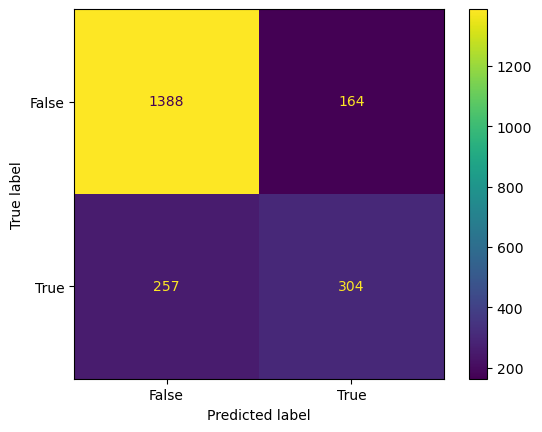

In [310]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [311]:
# Extract TN, TP, FN and FP from conf_matrix
TN = confusion_matrix[0,0]
TP =  confusion_matrix[1,1]
FN =  confusion_matrix[1,0]
FP =  confusion_matrix[0,1]
# Calculate and print the accuracy
accuracy = (TN +TP)/(TN+TP+FN+FP)
print("accuracy: ", accuracy)

# Calculate and print the sensitivity
sensitivity = TP/(TP+FN)
print("sensitivity: ", sensitivity)

# Calculate and print the specificity
specificity = TN/(TN+FP)
print("specificity: ", specificity)

accuracy:  0.8007572172266919
sensitivity:  0.5418894830659536
specificity:  0.8943298969072165


This model has an accuracy of 80% This is good but uses a lot of feautures.  I will remove variables based off of my knowledge gained through EDA.

In [312]:
#Creating Test Train Splits
predictors =['tenure', 'MonthlyCharges', 'SeniorCitizen_1', 'DeviceProtection_No',
       'OnlineSecurity_No','InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month','PaymentMethod_Electronic check','TechSupport_No']
response = ["Churn"]

X= telco.loc[:,predictors]
y= telco.loc[:,response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [313]:
# Fitting Logistic Regression Model
logreg.fit(X_train,y_train["Churn"])

# Predicting on test set

y_pred = logreg.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test["Churn"], y_pred)

display(confusion_matrix)

# Extract TN, TP, FN and FP from conf_matrix
TN = confusion_matrix[0,0]
TP =  confusion_matrix[1,1]
FN =  confusion_matrix[1,0]
FP =  confusion_matrix[0,1]
# Calculate and print the accuracy
accuracy = (TN +TP)/(TN+TP+FN+FP)
print("accuracy: ", accuracy)

# Calculate and print the sensitivity
sensitivity = TP/(TP+FN)
print("sensitivity: ", sensitivity)

# Calculate and print the specificity
specificity = TN/(TN+FP)
print("specificity: ", specificity)


pd.DataFrame(zip(X.columns, logreg.coef_.tolist()[0]))

array([[1387,  165],
       [ 267,  294]], dtype=int64)

accuracy:  0.795551348793185
sensitivity:  0.5240641711229946
specificity:  0.8936855670103093


,0,1
0,tenure,-0.030610
1,MonthlyCharges,0.014633
2,SeniorCitizen_1,0.259706
3,DeviceProtection_No,0.039044
4,OnlineSecurity_No,0.527826
5,InternetService_Fiber optic,0.419836
6,InternetService_No,0.090749
7,Contract_Month-to-month,0.916858
8,PaymentMethod_Electronic check,0.434900
9,TechSupport_No,0.431515


This still gives us a good accuracy with a lot less variables. These variables will be checked against the result of the random forest later.

## K-Fold Cross Validation

In [315]:
# evaluate a logistic regression model using k-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
predictors =['tenure', 'MonthlyCharges','SeniorCitizen_1', 'DeviceProtection_No',
       'OnlineSecurity_No','InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month','PaymentMethod_Electronic check','TechSupport_No']
response = ["Churn"]

X= telco.loc[:,predictors]
y= telco.loc[:,response]

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))




Accuracy: 0.796 (0.013)


Here we see the kfold cross validation shows an average accuracy of 80%

# Classifiaction Tree

In [316]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [317]:
#Creating Test Train Splits
predictors =['tenure', 'MonthlyCharges',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
response = ["Churn"]

X= telco.loc[:,predictors]
y= telco.loc[:,response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [344]:

#Instantiate dt
dt = DecisionTreeClassifier(max_depth = 2 , random_state=1)
# fit dt to training set
dt.fit(X_train, y_train)
#Predict the test set
y_pred = dt.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test["Churn"], y_pred)
display(confusion_matrix)

display(accuracy_score(y_test,y_pred))

array([[1261,  291],
       [ 218,  343]], dtype=int64)

0.759110269758637

Playing arround with the max depth I found the best accuracy came with a max depth of 5. The Decision Tree gave an accuracy of 79.5%

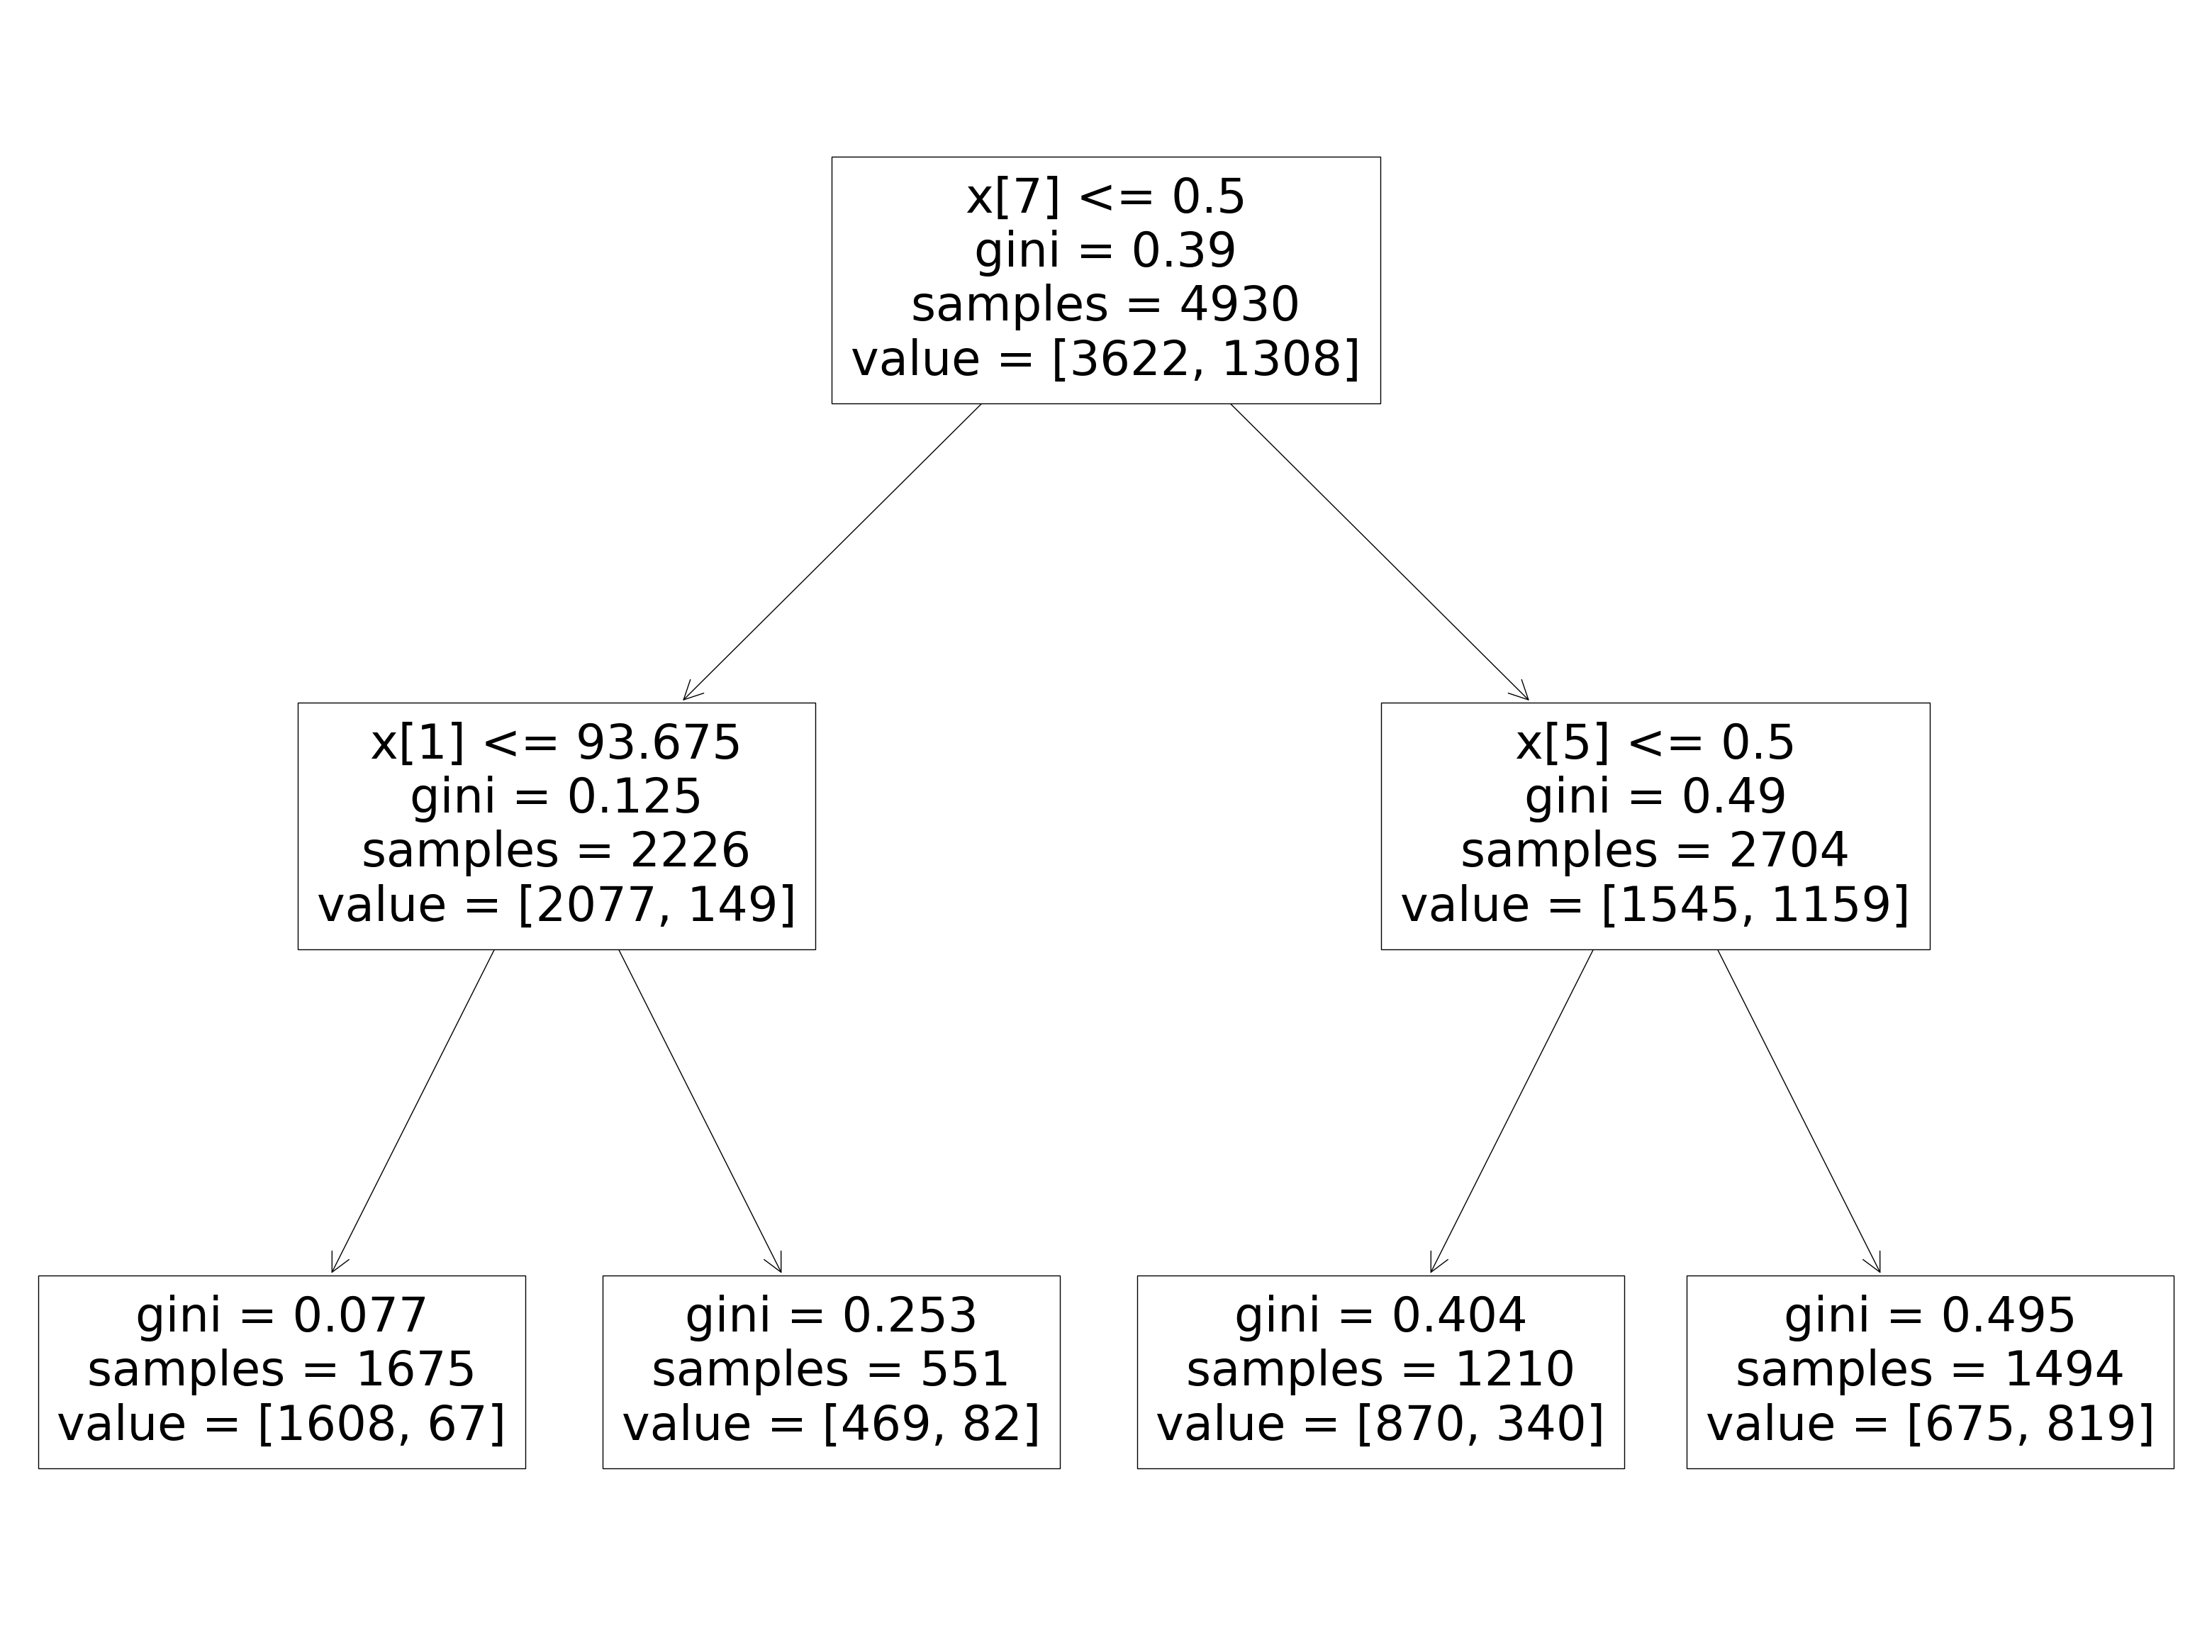

In [345]:
from sklearn import tree
fig = plt.figure(figsize=(40,30))
tree = tree.plot_tree(dt)


## Random Forest

In [319]:
from sklearn.ensemble import RandomForestClassifier


In [320]:
#Creating Test Train Splits
predictors =['tenure', 'MonthlyCharges', 
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
response = ["Churn"]

X= telco.loc[:,predictors]
y= telco.loc[:,response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [343]:
rf = RandomForestClassifier(max_depth = 5, random_state = 1)

rf.fit(X_train,y_train["Churn"])

y_pred = rf.predict(X_test)
print(accuracy_score(y_test,y_pred))
confusion_matrix = metrics.confusion_matrix(y_test["Churn"], y_pred)

print(confusion_matrix)

0.7979176526265973
[[1431  121]
 [ 306  255]]


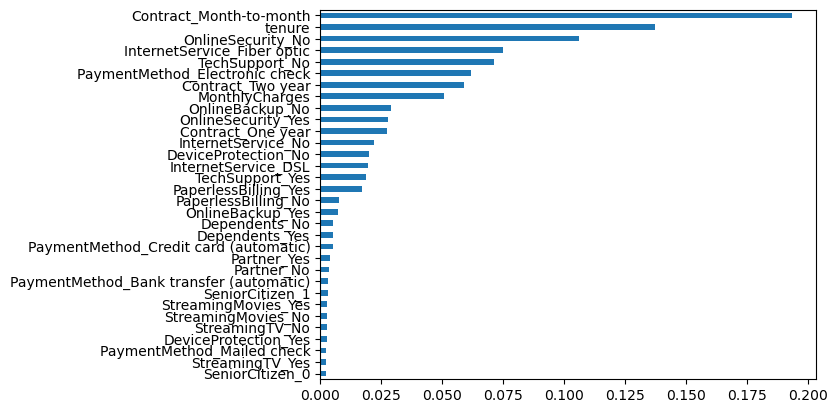

In [322]:
importance_rf = pd.Series(rf.feature_importances_, index = X.columns)

sorted_importance_rf = importance_rf.sort_values()

sorted_importance_rf.plot(kind = 'barh')

plt.show()

In [323]:
importance_rf_cum = importance_rf.sort_values(ascending = False).cumsum()
display(importance_rf_cum.head(15))

Contract_Month-to-month           0.193444
tenure                            0.330489
OnlineSecurity_No                 0.436307
InternetService_Fiber optic       0.511062
TechSupport_No                    0.582089
PaymentMethod_Electronic check    0.643844
Contract_Two year                 0.702617
MonthlyCharges                    0.753436
OnlineBackup_No                   0.782524
OnlineSecurity_Yes                0.810489
Contract_One year                 0.838087
InternetService_No                0.859963
DeviceProtection_No               0.880011
InternetService_DSL               0.899816
TechSupport_Yes                   0.918740
dtype: float64

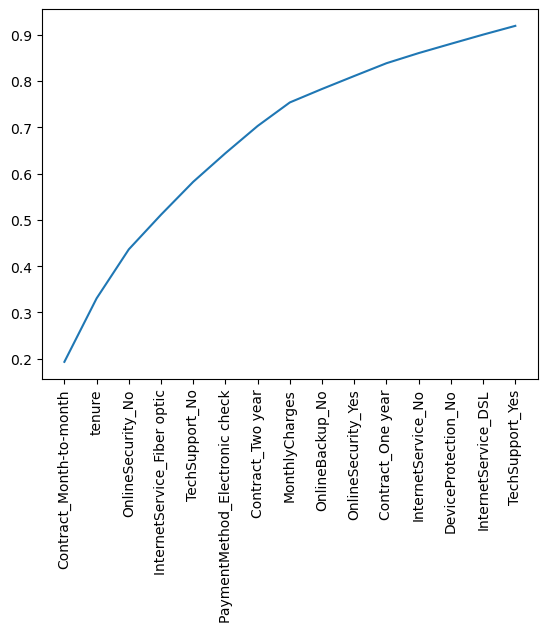

In [341]:
important_col =['Contract_Month-to-month', 'tenure', 'OnlineSecurity_No',
       'InternetService_Fiber optic', 'TechSupport_No',
       'PaymentMethod_Electronic check', 'Contract_Two year', 'MonthlyCharges',
       'OnlineBackup_No', 'OnlineSecurity_Yes', 'Contract_One year',
       'InternetService_No', 'DeviceProtection_No', 'InternetService_DSL',
       'TechSupport_Yes']
importance_rf_cum.head(15).plot()
plt.xticks(ticks = range(0,15), labels = important_col, rotation = 90)
plt.title
plt.show()

The top 15 line up with what I found in the EDA.

In [325]:
importance_rf_cum.head(15).index

Index(['Contract_Month-to-month', 'tenure', 'OnlineSecurity_No',
       'InternetService_Fiber optic', 'TechSupport_No',
       'PaymentMethod_Electronic check', 'Contract_Two year', 'MonthlyCharges',
       'OnlineBackup_No', 'OnlineSecurity_Yes', 'Contract_One year',
       'InternetService_No', 'DeviceProtection_No', 'InternetService_DSL',
       'TechSupport_Yes'],
      dtype='object')

# Refitting Logistic Regression

In [326]:
important_col =['Contract_Month-to-month', 'tenure', 'OnlineSecurity_No',
       'InternetService_Fiber optic', 'TechSupport_No',
       'PaymentMethod_Electronic check', 'Contract_Two year', 'MonthlyCharges',
       'OnlineBackup_No', 'OnlineSecurity_Yes', 'Contract_One year',
       'InternetService_No', 'DeviceProtection_No', 'InternetService_DSL',
       'TechSupport_Yes']

In [327]:
for i in range(15) :
        #Creating Test Train Splits
        predictors = important_col[0:1+i]
        response = ["Churn"]

        X= telco.loc[:,predictors]
        y= telco.loc[:,response]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

        # Fitting Logistic Regression Model
        logreg.fit(X_train,y_train["Churn"])

        # Predicting on test set

        y_pred = logreg.predict(X_test)


        print(accuracy_score(y_test,y_pred))
        


0.73450070989115
0.73450070989115
0.7737813535257927
0.7908187411263606
0.79649787032655
0.7993374349266446
0.7993374349266446
0.7908187411263606
0.792238523426408
0.792238523426408
0.7927117841930904
0.7927117841930904
0.7931850449597728
0.7931850449597728
0.7931850449597728


The 6th entry has the highest accuracy
# K-fold with Best Features

In [328]:
predictors = important_col[0:6]
response = ["Churn"]

X= telco.loc[:,predictors]
y= telco.loc[:,response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.796 (0.017)


## K-fold Forward Stepwise Regression

In [329]:
for i in range(15) :
        #Creating Test Train Splits
        predictors = important_col[0:1+i]
        response = ["Churn"]

        X= telco.loc[:,predictors]
        y= telco.loc[:,response]
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        cv = KFold(n_splits=10, random_state=1, shuffle=True)
        # create model
        model = LogisticRegression()
        # evaluate model
        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        # report performance
        print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.735 (0.016)
Accuracy: 0.734 (0.017)
Accuracy: 0.776 (0.019)
Accuracy: 0.786 (0.016)
Accuracy: 0.787 (0.013)
Accuracy: 0.796 (0.017)
Accuracy: 0.795 (0.017)
Accuracy: 0.794 (0.017)
Accuracy: 0.796 (0.018)
Accuracy: 0.797 (0.017)
Accuracy: 0.796 (0.017)
Accuracy: 0.796 (0.016)
Accuracy: 0.796 (0.017)
Accuracy: 0.796 (0.017)
Accuracy: 0.796 (0.016)


K-fold shows that using the 10 top entries gives you best accuracy for 

In [331]:
important_col[0:10]

['Contract_Month-to-month',
 'tenure',
 'OnlineSecurity_No',
 'InternetService_Fiber optic',
 'TechSupport_No',
 'PaymentMethod_Electronic check',
 'Contract_Two year',
 'MonthlyCharges',
 'OnlineBackup_No',
 'OnlineSecurity_Yes']

In [330]:
predictors = important_col[0:10]
response = ["Churn"]

X= telco.loc[:,predictors]
y= telco.loc[:,response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y)

# Fitting Logistic Regression Model
logreg.fit(X_train,y_train["Churn"])
y_pred = logreg.predict(X_test)
print(accuracy_score(y_pred, y_test))

confusion_matrix = metrics.confusion_matrix(y_test["Churn"], y_pred)

print(confusion_matrix)
pd.DataFrame(zip(X.columns, logreg.coef_.tolist()[0]))

0.7988641741599621
[[1394  158]
 [ 267  294]]


,0,1
0,Contract_Month-to-month,0.764082
1,tenure,-0.027518
2,OnlineSecurity_No,0.340415
3,InternetService_Fiber optic,0.685945
4,TechSupport_No,0.434559
5,PaymentMethod_Electronic check,0.406120
6,Contract_Two year,-0.667231
7,MonthlyCharges,0.008173
8,OnlineBackup_No,0.215177
9,OnlineSecurity_Yes,-0.154341


# KNN

In [332]:
from sklearn.neighbors import KNeighborsClassifier

In [333]:
knn = KNeighborsClassifier(n_neighbors = 10)

#Predictors from EDA
predictors =['tenure', 'MonthlyCharges','SeniorCitizen_1', 'DeviceProtection_No',
       'OnlineSecurity_No','InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month','PaymentMethod_Electronic check','TechSupport_No']
response = ["Churn"]

X= telco.loc[:,predictors]
y= telco.loc[:,response]

#Train/Test Split 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Fitting Model
knn.fit(X_train, y_train["Churn"])

#Predicting Values
y_pred = knn.predict(X_test)


#accuracy
accuracy_score(y_pred, y_test["Churn"])

0.7780407004259347

Using a KNN with 10 nearest neighbors gives us an accuracy around 78%

In [334]:

test_accuracies = {}

neigh = np.arange(1,50)

for n in neigh :
    knn = knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train["Churn"])
    y_pred = knn.predict(X_test)
    test_accuracies[n] = accuracy_score(y_pred, y_test["Churn"])


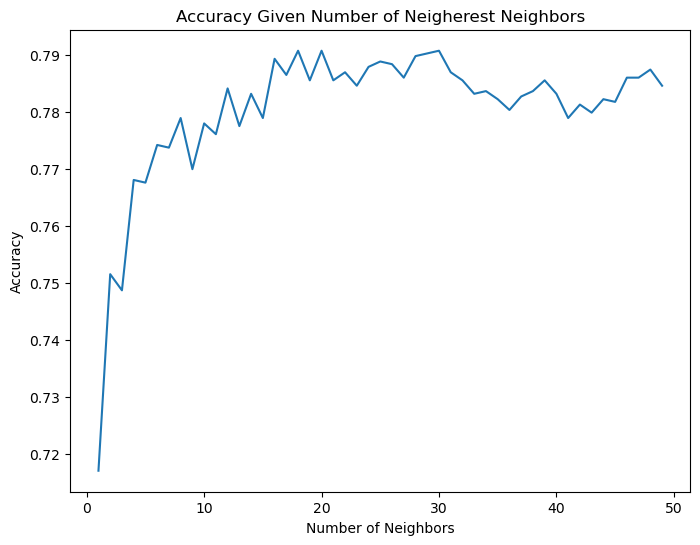

In [335]:
plt.figure(figsize =(8,6))
plt.title("Accuracy Given Number of Neigherest Neighbors")
plt.plot(neigh, test_accuracies.values())
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [336]:
max_accuracy = max(test_accuracies.values())


neighbors_for_max = list(test_accuracies.keys())[list(test_accuracies.values()).index(max_accuracy)]

print(str(neighbors_for_max) + " nearest neighbors gives a max accuracy of " + str(max_accuracy))

18 nearest neighbors gives a max accuracy of 0.7908187411263606


## K fold Cross validation

In [337]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = KNeighborsClassifier(n_neighbors = 18)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.787 (0.018)


The K-fold Cross validation yields an accuracy of 78.7%

In [338]:
knn = KNeighborsClassifier(n_neighbors = 12)

X= telco.loc[:,predictors]
y= telco.loc[:,response]

#Train/Test Split 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Fitting Model
knn.fit(X_train, y_train["Churn"])

#Predicting Values
y_pred = knn.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test["Churn"], y_pred)
#accuracy
print(accuracy_score(y_pred, y_test["Churn"]))
print(confusion_matrix)

0.7841930903928065
[[1414  138]
 [ 318  243]]
